In [56]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
from tqdm import tqdm
import holoviews as hv
import bokeh

Data

In [57]:
np.random.seed(0)  # For reproducibility

def getX1() :
    n_samples = 20000
    X1 = np.random.normal(0, 1, n_samples)
    return X1

def getX2(X1) :
    X2 = 3 * X1 + 4  # X1 and X2 are linearly related
    return X2

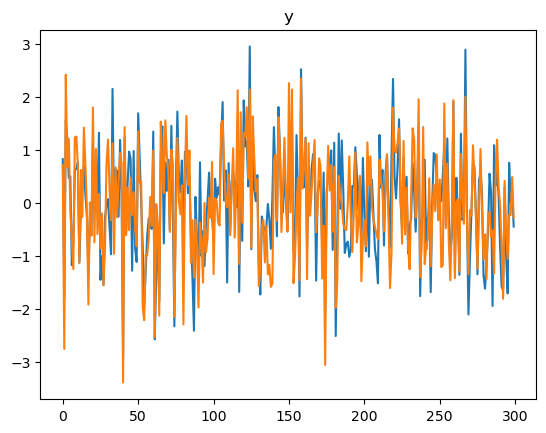

array([[ 8.23140980e-01,  7.14248070e-01],
       [-1.80441236e+00, -2.75155396e+00],
       [ 1.55278284e+00,  2.41553205e+00],
       [ 1.22100785e+00,  6.77249707e-01],
       [ 4.68857003e-01,  1.20525962e+00],
       [ 5.01493600e-01, -1.25148581e-01],
       [-1.17478937e+00, -6.87079943e-01],
       [-7.38363148e-01, -1.24825691e+00],
       [ 6.31158124e-01,  1.23282424e+00],
       [ 6.39952188e-01,  1.24959965e+00],
       [ 7.60061591e-01,  7.03767220e-01],
       [-1.12468855e+00, -1.13587138e+00],
       [-1.53757908e-01,  6.22132346e-01],
       [ 3.71518059e-01, -2.63669124e-01],
       [ 6.97168120e-01,  1.41879172e+00],
       [ 1.59433060e-01,  7.33901226e-01],
       [-2.44523152e-01, -1.16270422e-01],
       [-1.34278617e+00, -1.91713893e+00],
       [-2.74177873e-01,  7.16612992e-03],
       [-6.04203709e-01, -6.18126192e-01],
       [ 1.15852727e+00,  1.79844353e+00],
       [-1.46575337e-01, -7.44259485e-01],
       [ 8.57876244e-01,  1.01399750e+00],
       [-1.

In [67]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)
plt.plot(y)
plt.title("y")
plt.show()
y

Network

In [58]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # The input layer now takes a single feature
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1(x1))
        x2 = F.relu(self.fc1(x2))  # Apply the first layer to both inputs
        x = (x1 + x2) / 2  # This gives you a tensor of shape (20000, 64)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [59]:
mine_net = SimpleNet()
mine_optimizer = torch.optim.Adam(mine_net.parameters(), lr=0.01)

MiNe

In [60]:
def mutual_information(joint1, joint2, marginal, ma_rate=0.01):

    T = mine_net(joint1, joint2)
    eT = torch.exp(mine_net(joint1, marginal))
    # The neural information measure by the Donskar-Varadhan representation
    NIM = torch.mean(T) - torch.log(torch.mean(eT))

    #Using exponantial moving average to correct bias
    ma_eT = (1-ma_rate)*eT + (ma_rate)*torch.mean(eT)
    # unbiasing
    loss = -(torch.mean(T) - (1/ma_eT.mean()).detach()*torch.mean(eT))
    # use biased estimator
        
    return NIM, loss

Loop

In [63]:
plot_loss = []
n_epoch = 50

for epoch in tqdm((range(n_epoch))):
    x_sample=getX1()
    y_sample=getX2(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True).view(-1, 1)
    
    ret, loss = mutual_information(x_sample, y_sample, y_shuffle)
    
    mine_optimizer.zero_grad()
    autograd.backward(loss)
    mine_optimizer.step()
        
    plot_loss.append(loss.data.numpy())

100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


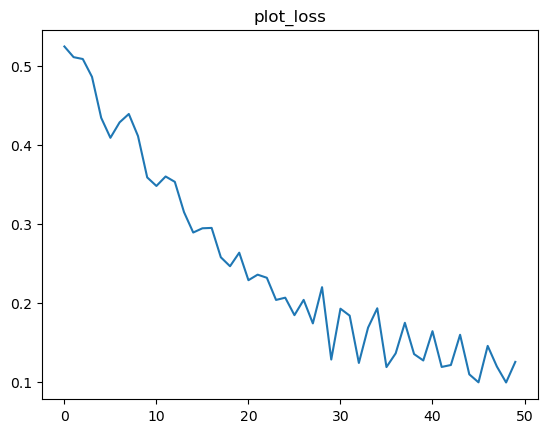

In [64]:
plt.plot(plot_loss)
plt.title("plot_loss")
plt.show()